# Classifying individuals with chronic kidney disease based on age, blood urea level, and serum creatinine level

#### Aahil Tejani, Emily Xie, Emily Yip, Sarah Chan

## Introduction

Chronic kidney disease (CKD) occurs when the kidneys have been damaged over time and are unable to perform their functions. These functions include maintaining blood pressure, removing waste products, making red blood cells, and keeping the body balanced (National Kidney Foundation, 2024). This increases the risk of heart disease and stroke. Common symptoms include nausea, fatigue, urinating issues, decreased brain activity, and high blood pressure (National Kidney Foundation, 2024). However, symptoms resemble common illnesses, complicating early diagnosis without medical attention.

Those over the age of 60 years are at higher risk of CKD, as well as those with higher blood urea levels due to increased toxins from kidney failure (Laville et al., 2022). Elevated levels of serum creatinine, a waste product removed by kidneys, may also be an indicator of kidney failure (National Kidney Foundation, 2024). Hence, we propose to use these risk factors to classify patients if they have CKD.

In summary, the goal of this project is to use the risk factors such as age, level of blood urea and serum creatinine to classify patients based on their likeliness of having chronic kidney disease. Therefore, we will be addressing the question: **Is a new patient likely to have chronic kidney diseases based on age, blood urea level, and serum creatinine level?**

To achieve this, we will create a model using the data set Chronic Kidney Disease from UC Irvine Machine Learning Repository (Rubini et al., 2015). The data was collected during a two month period in India with 25 variables. The dataset has 25 columns with one of them being the Class (**ckd**). 


## Preliminary Exploratory Data Analysis

In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#set seed
set.seed(1)

#Read file from github and turn into csv
url = "https://raw.githubusercontent.com/schan26/dsci-100-grp18/main/chronic_kidney_disease_full.arff"
download.file(url, "ckd_data.csv")
ckd_data <- read_delim("ckd_data.csv", delim = ",", col_names = FALSE, skip = 145)

#add column names
colnames(ckd_data) <- c("age", "blood_pressure", "specific_gravity", 
                                    "albumin", "sugar", "red_blood_cells", "pus_cell", 
                                    "pus_cell_clumps", "bacteria", "blood_glucose_random", 
                                    "blood_urea", "serum_creatinine", "sodium", "potassium", 
                                    "hemoglobin", "packed_cell_volume", "white_blood_cell_count", 
                                    "red_blood_cell_count", "hypertension", "diabetes_mellitus", 
                                    "coronary_artery_disease", "appetite", "pedal_edema", 
                                    "anemia", "ckd")
#wrangling data
ckd_data[ckd_data == "?"] <- NA
ckd_data[ckd_data == "ckd" | ckd_data == "ckd," | ckd_data == "ckd\t"] <- "yes" #rename data to make it more readable
ckd_data[ckd_data == "no,notckd" | ckd_data == "notckd"] <- "no"

#Change to correct type
ckd_data[,c(1:5,10:18)] <- sapply(ckd_data[, c(1:5,10:18)], as.numeric )
ckd_data[,c(6:9,19:25)] <- lapply(ckd_data[, c(6:9,19:25)], as.factor )

#Selecting our predictors and varaiable only
ckd_analysis <- ckd_data |>
    select(ckd, age, blood_urea, serum_creatinine) |>
    na.omit()
head(ckd_analysis)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 400 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”
Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”
Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”


ckd,age,blood_urea,serum_creatinine
<fct>,<dbl>,<dbl>,<dbl>
yes,48,36,1.2
yes,7,18,0.8
yes,62,53,1.8
yes,48,56,3.8
yes,51,26,1.4
yes,60,25,1.1


*Figure 1: the first 6 rows of our cleaned dataset*

We first loaded in the original dataset from an URL, then cleaned up the data by:
1. renaming the column names,
2. changing all cells with missing data "?" to NA,
3. changing the data type to its correct data type (eg. from char to double or factor),
4. renaming our class labels to "yes" and "no" to represent having CKD and not having CKD,
5. selecting only our predictors **age**, **blood_urea**, **serum_creatinine**, and the class variable **ckd**,
6. removed all observations with NA values so that we can perform knn-classification with tidymodels later on. 

In [3]:
set.seed(9999)
#splitting data into training and testing datasets
ckd_data_split <- initial_split(ckd_analysis, prop = 0.75, strata = ckd)

ckd_training <- training(ckd_data_split)
ckd_testing <- testing(ckd_data_split)

glimpse(ckd_training)

Rows: 278
Columns: 4
$ ckd              <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…
$ age              <dbl> 40, 23, 45, 57, 34, 60, 38, 30, 49, 45, 42, 50, 48, 2…
$ blood_urea       <dbl> 10, 36, 49, 17, 27, 10, 36, 38, 32, 46, 24, 40, 33, 1…
$ serum_creatinine <dbl> 1.2, 1.0, 0.6, 1.2, 1.2, 0.5, 0.7, 1.0, 1.2, 1.2, 0.7…


*Figure 2: A glimpse of the training set*

We then splitted our dataset into training and testing datasets using the `initial_split()` function.

In [4]:
#exploratory data analysis: summarizing the min, max, mean of each predictor +
#                           total num of rows in each class
ckd_analysis <- ckd_training |>
    group_by(ckd) |>
    summarize(count = n(), 
              min_age = min(age, na.rm = TRUE), max_age = max(age, na.rm = TRUE), mean_age = mean(age, na.rm = TRUE),
              min_sc = min(serum_creatinine, na.rm = TRUE), max_sc = max(serum_creatinine, na.rm = TRUE), mean_sc = mean(serum_creatinine, na.rm = TRUE),
              min_bu = min(blood_urea, na.rm = TRUE), max_bu = max(blood_urea, na.rm = TRUE), mean_bu = mean(blood_urea, na.rm = TRUE))

#Number of missing values in each predictor
# ckd_NA <- ckd_training |>
#     group_by(ckd) |>
#     select(ckd, age, blood_urea, serum_creatinine) |>
#     summarise(across(,  ~sum(is.na(.)))) |>
#     pivot_longer(cols = -ckd, names_to = "column", values_to = "count_na")

ckd_analysis
# ckd_NA

ckd,count,min_age,max_age,mean_age,min_sc,max_sc,mean_sc,min_bu,max_bu,mean_bu
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,107,12,80,46.57009,0.4,1.2,0.8728972,10.0,50,32.16822
yes,171,3,90,54.70760,0.6,48.1,4.0909357,1.5,391,70.42807


*Figure 3: Summary statistics of our training dataset* 

We then performed exploratory data analysis on our training dataset, finding the mininum, maximum, and mean of each predictor, grouped by the class variable **ckd**.

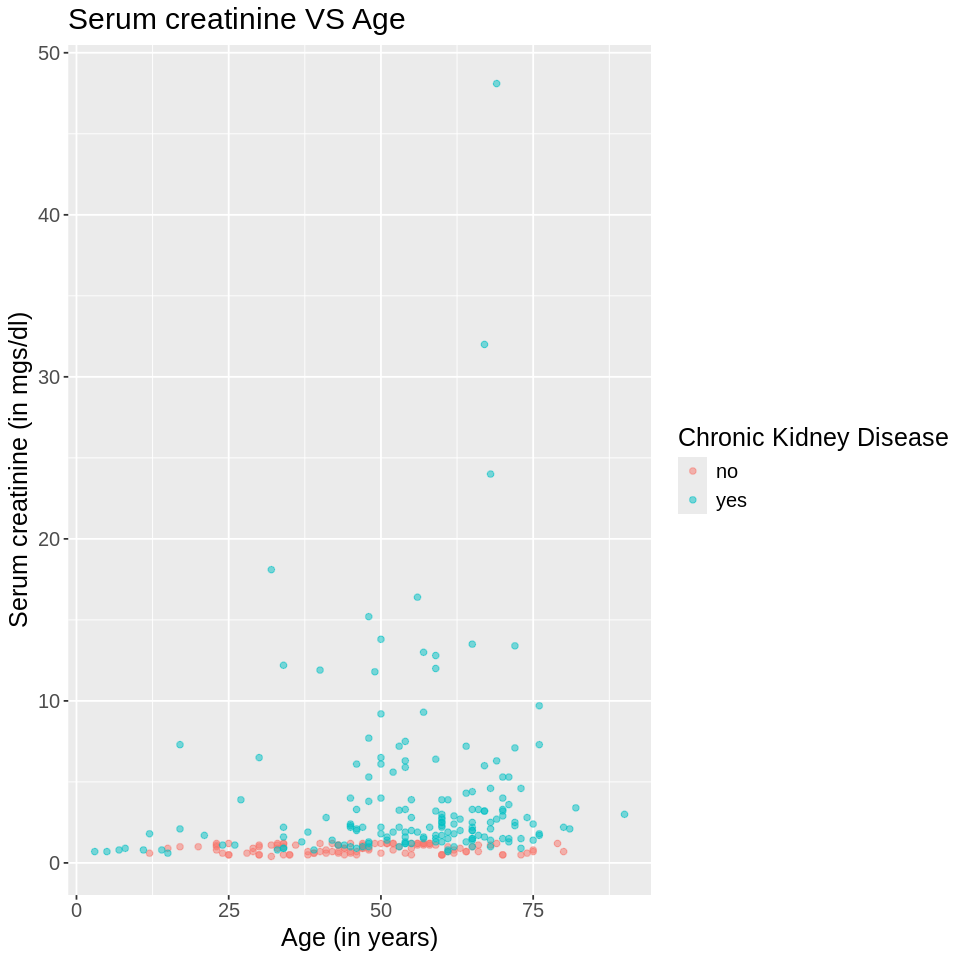

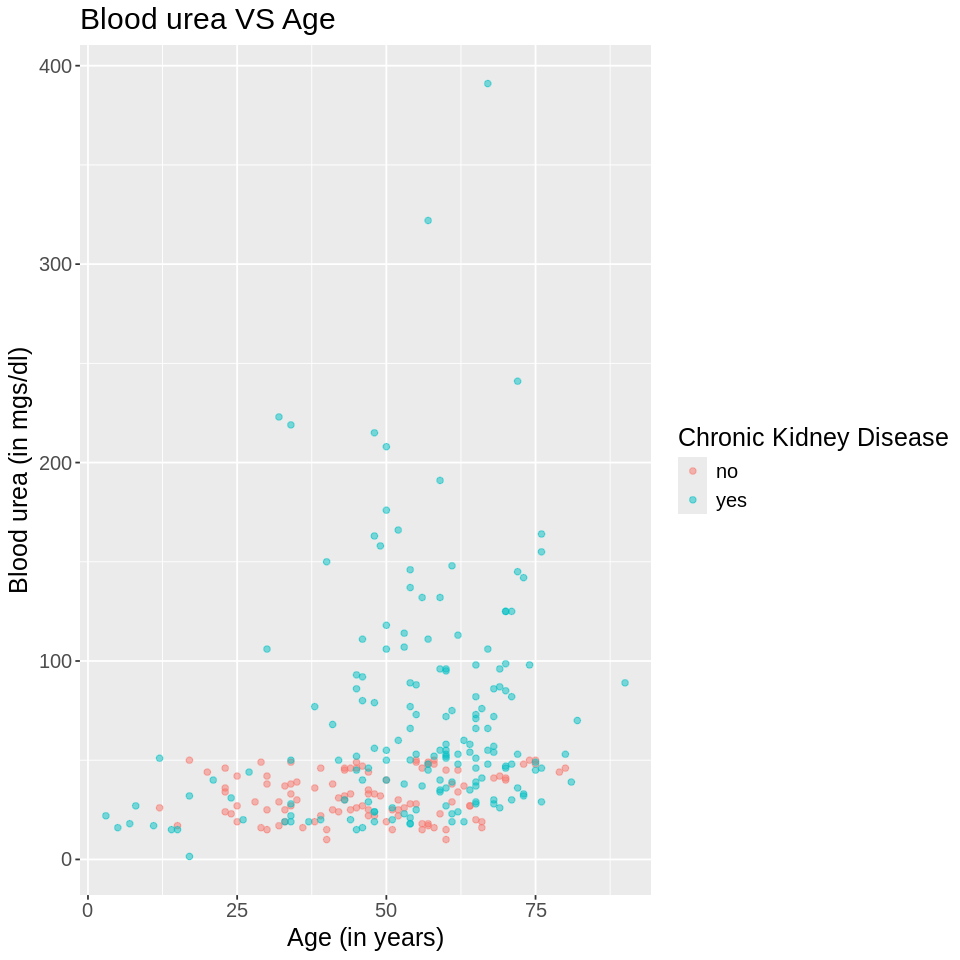

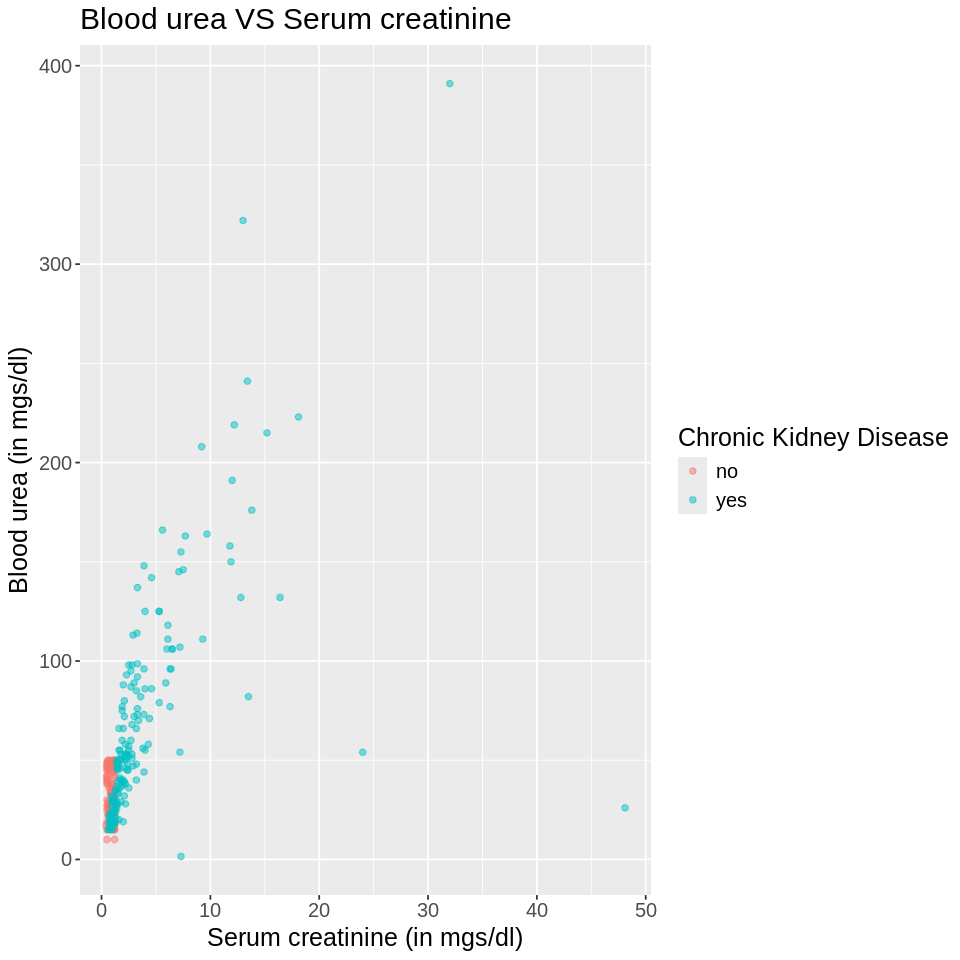

In [5]:
#plotting training data 
options(repr.plot.width = 8, repr.plot.height = 8) 
plot1 <- ggplot(ckd_training, aes(x = age, y = serum_creatinine, color = ckd)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (in years)", y = "Serum creatinine (in mgs/dl)", color = "Chronic Kidney Disease") +
    ggtitle("Serum creatinine VS Age") +
    theme(text=element_text(size=15))

plot2 <- ggplot(ckd_training, aes(x = age, y = blood_urea, color = ckd)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (in years)", y = "Blood urea (in mgs/dl)", color = "Chronic Kidney Disease") +
    ggtitle("Blood urea VS Age") +
    theme(text=element_text(size=15))

plot3 <- ggplot(ckd_training, aes(x = serum_creatinine, y = blood_urea, color = ckd)) +
    geom_point(alpha = 0.5) +
    labs(x = "Serum creatinine (in mgs/dl)", y = "Blood urea (in mgs/dl)", color = "Chronic Kidney Disease") +
    ggtitle("Blood urea VS Serum creatinine") +
    theme(text=element_text(size=15))

plot1
plot2
plot3

*Figure 4: 3 plots of showing the relationship between the predictors*

We created scatterplots to show the relationship betweeen the predictors for our exploratory data analysis. 

From the above figure, we can see that all predictors have a positive relationship with each other if the patient has chronic kidney disease (CKD), while there is no relationship if the patient doesn't have CKD. If CKD is present, the values tend to be larger, while values are generally smaller if there is no CKD.

Therefore, based on our visualization, our choces of predictors should be able to make accurate predictions of the class variable **ckd**.

## Data Analysis

accuracy_estimate
<dbl>
0.8377717


[1] 4

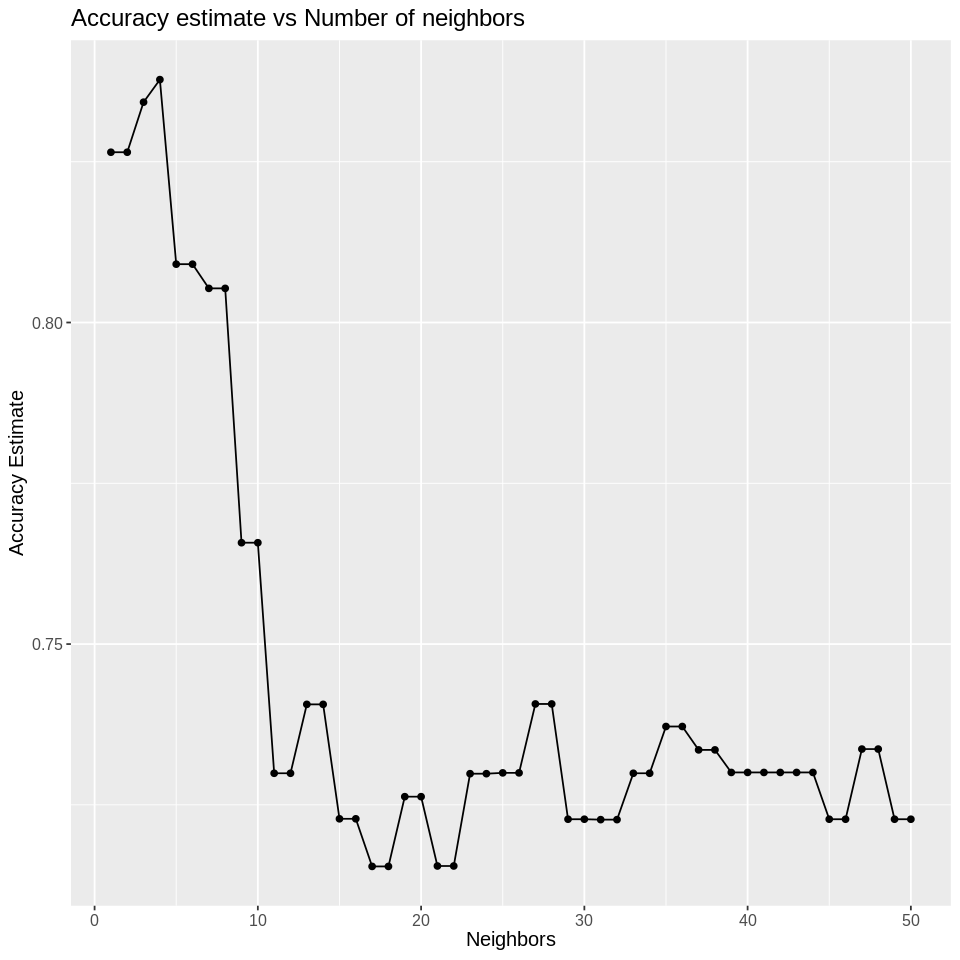

In [11]:
#knn-classification using tidymodels
set.seed(9999)
options(repr.matrix.max.rows = 15)

ckd_recipe <- recipe(ckd ~ age + serum_creatinine + blood_urea, data = ckd_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

ckd_vfold <- vfold_cv(ckd_training, v=5, strata=ckd) 

gridvals <- tibble(neighbors = seq(from = 1, to=50, by=1))

ckd_fit <- workflow() |>
    add_recipe(ckd_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = ckd_vfold, grid = gridvals) |>
    collect_metrics()

accuracies <- ckd_fit |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy estimate vs Number of neighbors") +
    theme(text = element_text(size = 12))
cross_val_plot

accuracies |> summarize(accuracy_estimate=max(mean))

best_k <- accuracies |>
    arrange(-mean) |>
    head(1) |>
    pull(neighbors)
best_k

*Figure 5.1: Value of maximum accuracy estimate*

*Figure 5.2: *k*-value with highest estimated accuracy*

*Figure 5.3: Plot of accuracy estimate versus the number of neighbors*

We first created the recipe and the model specification for tuning for the workflow model. Then we used a 5-fold cross-validation to determine the accuracy estimate for each number of neighbors *k*. After that, we made a plot of accuracy estimate versus the number of neighbors.

We then choose the number of neighbors *k* that has the highest accuracy estimate, which is **k=4**.

## Comparing to Majority Classifier

In [7]:
ckd_proportions <- ckd_training |>
    group_by(ckd) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(ckd_training))
ckd_proportions

ckd,n,percent
<fct>,<int>,<dbl>
no,107,38.48921
yes,171,61.51079


*Figure 6: A tibble showing the total number of observations for each class in the training set and the percentage of total observations it occupies*

Using the majority classifier, it would have an accuracy of around 62%. Comparing to our knn-classifier that has an accuracy of around 84%, we can conclude that our knn-classifier is more accurate than the majority classifier.

## Testing Our Model

In [8]:
# Final model
set.seed(9999)

knn_final <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

ckd_final_fit <- workflow() |>
    add_recipe(ckd_recipe) |>
    add_model(knn_final) |>
    fit(data = ckd_training)

In [9]:
#Predicting in testing dataset
set.seed(9999)

ckd_predictions <- predict(ckd_final_fit, ckd_testing) |>
    bind_cols(ckd_testing)

ckd_predictions |> pull(ckd) |> levels()

[1] "no"  "yes"

*Figure 7: Order of the class labels*

We are checking the order of the class labels for later use (finding precision and recall). 

We label "yes" as the "positive" class.

In [10]:
#Evaluation of our model
set.seed(9999)

ckd_accuracy <- ckd_predictions |>
    metrics(truth = ckd, estimate = .pred_class) |>
    filter(.metric == "accuracy")
ckd_accuracy

ckd_precision <- ckd_predictions |>
    precision(truth = ckd, estimate = .pred_class, event_level = "second")
ckd_precision

ckd_recall <- ckd_predictions |>
    recall(truth = ckd, estimate = .pred_class, event_level = "second")
ckd_recall

ckd_conf_mat <- ckd_predictions |>
    conf_mat(truth = ckd, estimate = .pred_class)
ckd_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8494624


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8909091


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8596491


          Truth
Prediction no yes
       no  30   8
       yes  6  49

*Figure 8: Values of accuracy, precision, recall, and the confusion matrix*

We now test our classification model on the testing set. We then obtained the accuracy, precision, and recall of our model. 

We can see a great improvement in accuracy for our model compared to the majority classifier.  

## Methods

#### Preprocess Data and Exploratory Data Analysis
1. We first loaded in our dataset from an URL and used `read_delim()` to read the data, then performed wrangling to make our data tidy by changing column types, names and removing observations with missing values. 
2. The predictor for our data analysis include **age**, **blood urea** and **serum creatine**. All these three variables are numerical, which allows us to make knn calculations.
3. Splitted our data into training and testing set, using only the **training set** until performance evaluation of our model.
4. Performed exploratory data analysis and summarized the **minimum**, **maximum**, **mean**, and **count** of total observations in our training dataset.
5. Created scatterplots to visualize the relationships between the predictors. We can see that as each variable increases, the other variables also tend to increase when the patient has chronic kidney disease, thus these three variables will be used as predictors. 

#### Picking the best *k* value for our model
1. Used `recipe()` to specify the class label **ckd** and all our predictors, as well as standardizing the predictors.
2. Created a model specification using `nearest_neighbors()` wtih `neighbors = tune()`.
3. Used `vfold_cv()` to create validation sets for 5-fold-cross-validation.
4. Added the recipe and model specification to a `workflow()`, then used `tune_grid()`on the validation sets to test the accuracy of *k* values ranged from 1 to 50.
5. Picked the *k* value witht the highest accuracy estimate.

#### Comparison to majority classifier
1. Grouped the training set by the class label **ckd** using `group_by()`.
2. Summarized the total number of rows for each class, and the percentage of total rows it occupies using `summarize()` and `mutate()`.
3. Compared the majority class with the estimated accuracy for our best *k* value.

#### Performance evaluation for our knn classifier
1. Created a new model specification with the *k* value that we picked, then retrained the classifier using `fit()`.
2. Evaluated the performance of our classifer using `predict()` on the testing dataset.
3. Found the **accuracy**, **precision**, **recall**, and **confusion matrix** of our classifier using `metrics()`, `precision()`, `recall()` and `conf_mat()` respectively.


## Discussion

#### Expectations and Summary of what we found
To answer the question of “Is a new patient likely to have chronic kidney diseases considering their age, blood urea, and serum creatinine?” We created a classifier to predict whether or not a patient has chronic kidney disease based on these three variables. 

We expected to find that a patient with chronic kidney disease will have higher levels of serum creatinine and blood urea and is older, and that our classifier would perform better than 60% accuracy. 

According to our k-nearest neighbours classifier using 4 neighbours, the prediction for chronic kidney disease is accurate 85% of the time. In comparison, the majority classifier has a prediction accuracy of 62% by predicting the most common outcome of our dataset. It is evident that our k-nearest neighbours model predicts significantly better. 
As seen in our confusion matrix, we can conclude that the accuracy of our classifier is relatively high (84.95%) for the testing CKD data set. Errors can be accounted to an imbalance of class as there are more patients with CKD than without in this dataset. 

Moreover, our model has a precision of 89.09%. Precision measures the accuracy of positive predictions made by the model. This figure reflects that 89% of the positive predictions are correctly classified. Additionally, our model has a recall of 85.96% which is also relatively high. Thus, the model is able to identify a large proportion of positive diagnoses, minimising false negatives.  

Overall, our findings were as expected: patients who are older, and have higher blood urea and serum creatinine levels are more likely to have chronic kidney disease. The graphs reflect that there are more CKD positive patients after the age of 37. Additionally, patients with serum creatinine levels over 1.5 mgs/dl and blood urea levels over 50 mgs/dl are more likely to have chronic kidney disease. However, there are still some cases of CKD below these levels.

#### Impacts of our findings

Such findings are significant in being able to classify patients with or without CKD more accurately and efficiently using a classification system as many of the visible symptoms are similar to those of general illness. This can cause CKD to not be detected until debilitating symptoms occur which are detrimental to the patient’s long term health. This leads to earlier treatment, preventing severe symptoms. For instance, if healthcare professionals had a way of recognizing specific markers, patients could be earlier diagnosed leading to higher efficiency. By initiating treatment as soon as the disease is detected with this classification system, doctors can seek out a treatment plan as soon as possible to ensure CKD does not further spread and continue to deteriorate the body. If CKD was detected at an earlier stage, less treatment and medication would be needed, minimising the risks of medication interactions and adverse side effects. A classification system would not only help patients with it's efficiency, but would also help the healthcare management system. By diagnosing patients in a more timely manner, time and resources can be used toward other tasks. 

Future ideas stemming from these findings are what other classification systems can be implemented in the medical system to enhance patient care and maximize effectiveness of the healthcare time and resources. For instance, Ilyas et. al (2021) demonstrates the effectiveness and accuracy of a chronic kidney disease classification system using decision tree algorithms. Similar to our project, their goal was to detect CKD symptoms to treat chronic kidney disease at the earliest stage.

#### What future questions could this lead to?
Future questions proposed are:
- How can we enhance this classification system with additional variables while maintaining simplicity?
- How can we classify factors to find ways to prevent CKD?

### Bibliography

Chronic Kidney Disease. (2024, March 6). National Kidney Foundation. https://www.kidney.org/atoz/content/about-chronic-kidney-disease#:~:text=Chronic%20kidney%20disease%20(CKD)%20is,very%20few%20symptoms%20at%20first.

Ilyas, H., Ali, S., Ponum, M., Hasan, O., Mahmood, M. T., Iftikhar, M., & Malik, M. H. (2021). Chronic kidney disease diagnosis using decision tree algorithms. BMC nephrology, 22(1), 273. https://doi.org/10.1186/s12882-021-02474-z

Laville, S. M., Couturier, A., Lambert, O., Metzger, M., Mansencal, N., Jacquelinet, C., Frimat, L., Fouque, D., Combe, C., Robinson, B. M., Stengel, B., Liabeuf, S., Massy, Z. A., Ayav, C., Briançon, S., Cannet, D., Fouque, D. (2022). Urea levels and cardiovascular disease in patients with chronic kidney disease. Nephrology Dialysis Transplantation, 38(1), 184–192. https://doi.org/10.1093/ndt/gfac045

Rubini, L., Soundarapandian, P., and Eswaran, P. (2015). Chronic Kidney Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C5G020.
